## Assignment 2 - Clustering

## Learning Outcomes

In this assignment, you will do the following:

* Explore a dataset and carry out clustering using k-means algorithm

* Identify the optimum number of clusters for a given dataset



## Problem Description

In this assignment, you will study the electricity demand from clients in Portugal, during 2013 and 2014. You have been provided with the data file, which you should download when you download this assignment file.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise, you will use clustering techniques to understand the typical usage behaviour during 2013-2014.

Both these datasets are publicly available, and can be used to carry out experiments. Their source is below:

 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm

We will start by exploring the data set and continue on to the assignment.  Consider this as a working notebook, you will add your work to the same notebook.

In this assignment we will use the sklearn package for k-means.  Please refer here for the documentation https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
(https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

The sklearn package for k-means is one of the many clustering algorithms found in the module "sklearn.cluster".  These come with a variety of functions that you can call by importing the package.

For example 
    
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.cluster import KMeans



## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed. The data file has been provided with this assignment. It is also available at the links provided above.

In [328]:
# ===================================
# Update this prior to submission!! 
# ===================================
pathToFile = r"C:\Users\Patty C\Downloads\assignment2-data\assignment2-data"

fileName = '\LD2011_2014.txt'

print(pathToFile+fileName)

C:\Users\Patty C\Downloads\assignment2-data\assignment2-data\LD2011_2014.txt


In [329]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

In [330]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [331]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [332]:
data.head(2)

MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  MT_007  \
2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                     MT_008  MT_009  MT_010  ...  MT_361  MT_362  MT_363  \
2011-01-01 00:15:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   

                     MT_364  MT_365  MT_366  MT_367  MT_368  MT_369  MT_370  
2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[2 rows x 370 columns]

In [333]:
data.tail(2)

MT_001     MT_002    MT_003      MT_004     MT_005  \
2014-12-31 23:45:00  1.269036  21.337127  1.737619  166.666667  85.365854   
2015-01-01 00:00:00  2.538071  19.914651  1.737619  178.861789  84.146341   

                         MT_006    MT_007      MT_008     MT_009     MT_010  \
2014-12-31 23:45:00  285.714286  10.17524  225.589226  64.685315  72.043011   
2015-01-01 00:00:00  279.761905  10.17524  249.158249  62.937063  69.892473   

                     ...      MT_361   MT_362       MT_363      MT_364  \
2014-12-31 23:45:00  ...  246.252677  28000.0  1443.037975  909.090909   
2015-01-01 00:00:00  ...  188.436831  27800.0  1409.282700  954.545455   

                        MT_365    MT_366      MT_367      MT_368      MT_369  \
2014-12-31 23:45:00  26.075619  4.095963  664.618086  146.911519  646.627566   
2015-01-01 00:00:00  27.379400  4.095963  628.621598  131.886477  673.020528   

                          MT_370  
2014-12-31 23:45:00  6540.540541  
2015-01-01 00:00:00  7135.135135  

[2 rows x 370 columns]

In [334]:
data.shape

(140256, 370)

#### As it can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [335]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [336]:
data.describe()

MT_001         MT_002         MT_003         MT_004  \
count  140256.000000  140256.000000  140256.000000  140256.000000   
mean        3.970785      20.768480       2.918308      82.184490   
std         5.983965      13.272415      11.014456      58.248392   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       2.844950       0.000000      36.585366   
50%         1.269036      24.893314       1.737619      87.398374   
75%         2.538071      29.871977       1.737619     115.853659   
max        48.223350     115.220484     151.172893     321.138211   

              MT_005         MT_006         MT_007         MT_008  \
count  140256.000000  140256.000000  140256.000000  140256.000000   
mean       37.240309     141.227385       4.521338     191.401476   
std        26.461327      98.439984       6.485684     121.981187   
min         0.000000       0.000000       0.000000       0.000000   
25%        15.853659      71.428571       0.565291     111.111111   
50%        39.024390     157.738095       2.826456     222.222222   
75%        54.878049     205.357143       4.522329     279.461279   
max       150.000000     535.714286      44.657999     552.188552   

              MT_009         MT_010  ...         MT_361         MT_362  \
count  140256.000000  140256.000000  ...  140256.000000  140256.000000   
mean       39.975354      42.205152  ...     218.213701   37607.987537   
std        29.814595      33.401251  ...     204.833532   38691.954832   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%        13.986014       9.677419  ...       5.710207       0.000000   
50%        40.209790      40.860215  ...     131.334761   24100.000000   
75%        57.692308      61.290323  ...     403.283369   54800.000000   
max       157.342657     198.924731  ...     852.962170  192800.000000   

              MT_363         MT_364         MT_365         MT_366  \
count  140256.000000  140256.000000  140256.000000  140256.000000   
mean     1887.427366    2940.031734      65.413150       9.269709   
std      1801.486488    2732.251967      65.007818      10.016782   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000      13.037810       0.000000   
50%      1050.632911    2136.363636      31.290743       7.021650   
75%      3312.236287    5363.636364     108.213820      11.702750   
max      7751.054852   12386.363636     335.071708      60.269163   

              MT_367         MT_368         MT_369         MT_370  
count  140256.000000  140256.000000  140256.000000  140256.000000  
mean      424.262904      94.704717     625.251734    8722.355145  
std       274.337122      80.297301     380.656042    9195.155777  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000      30.050083      83.944282       0.000000  
50%       525.899912      76.794658     758.064516       0.000000  
75%       627.743635     151.919866     875.366569   17783.783784  
max      1138.718174     362.270451    1549.120235   30918.918919  

[8 rows x 370 columns]

### Plot the first 2 days of 2012 for the first 2 clients

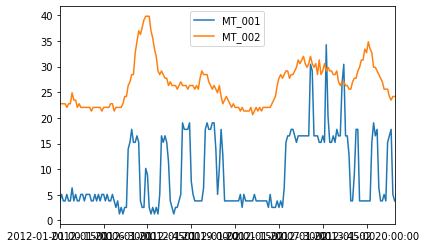

In [337]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We  note that the main difference between the curves is the level (also seen on the means in df.describe()).  We know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with low number of clients having zero demand

In [338]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [339]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [340]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [341]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [342]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [343]:
data['hour'] = data.index.map(lambda x: x[11:])  # create a new column specifically for the time 

In [344]:
data.head(3)

MT_001     MT_002    MT_003      MT_004     MT_005  \
2013-01-01 00:15:00  2.538071  22.759602  2.606429  138.211382  63.414634   
2013-01-01 00:30:00  1.269036  22.759602  2.606429  138.211382  63.414634   
2013-01-01 00:45:00  2.538071  22.759602  2.606429  134.146341  60.975610   

                         MT_006    MT_007      MT_008     MT_009     MT_010  \
2013-01-01 00:15:00  255.952381  4.522329  239.057239  57.692308  78.494624   
2013-01-01 00:30:00  264.880952  5.652911  228.956229  57.692308  76.344086   
2013-01-01 00:45:00  250.000000  5.652911  239.057239  54.195804  76.344086   

                     ...   MT_362      MT_363       MT_364     MT_365  \
2013-01-01 00:15:00  ...  22300.0  886.075949  1000.000000  16.949153   
2013-01-01 00:30:00  ...  21000.0  864.978903   909.090909  18.252934   
2013-01-01 00:45:00  ...  18200.0  860.759494   840.909091  16.949153   

                       MT_366      MT_367     MT_368      MT_369       MT_370  \
2013-01-01 00:15:00  6.436513  616.330114  76.794658  731.671554  8086.486486   
2013-01-01 00:30:00  3.510825  564.530290  76.794658  727.272727  8086.486486   
2013-01-01 00:45:00  5.851375  590.869183  68.447412  730.205279  7848.648649   

                         hour  
2013-01-01 00:15:00  00:15:00  
2013-01-01 00:30:00  00:30:00  
2013-01-01 00:45:00  00:45:00  

[3 rows x 350 columns]

### Getting average curves per client

In [345]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 
average_curves.head(3)

MT_001     MT_002    MT_003      MT_004     MT_005      MT_006  \
hour                                                                         
00:00:00  5.008344  26.045909  1.938755  130.551843  60.374206  191.136660   
00:15:00  4.917947  25.833512  1.911381  125.863125  57.586034  179.297130   
00:30:00  4.984007  24.754964  1.909001  121.566990  55.476111  171.554958   

            MT_007      MT_008     MT_009     MT_010  ...      MT_361  \
hour                                                  ...               
00:00:00  7.772366  242.027582  51.585401  54.837237  ...  119.625903   
00:15:00  7.426996  232.516950  50.016764  53.424658  ...  119.540837   
00:30:00  7.179972  225.317098  48.843280  52.514361  ...  111.557303   

                MT_362       MT_363       MT_364     MT_365     MT_366  \
hour                                                                     
00:00:00  36306.438356  1333.223513  1652.677460  37.831080  16.499275   
00:15:00  32137.534247   979.064794  1443.711083  33.942955  16.580232   
00:30:00  27249.178082   938.598925  1324.501868  31.044275  15.940589   

              MT_367      MT_368      MT_369        MT_370  
hour                                                        
00:00:00  676.790504  148.683880  799.235729  17333.891151  
00:15:00  659.875882  155.464587  795.100028  17466.227323  
00:30:00  655.911819  153.879754  777.630258  17605.301740  

[3 rows x 349 columns]

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [346]:
average_curves_norm = average_curves/(average_curves.mean())
average_curves_norm.tail(3)

MT_001    MT_002    MT_003    MT_004    MT_005    MT_006  \
hour                                                                   
23:15:00  1.031768  0.954925  1.003976  1.238946  1.324550  1.179398   
23:30:00  1.006652  0.923346  0.998497  1.209744  1.272842  1.115396   
23:45:00  1.001629  0.926570  0.993017  1.175290  1.231541  1.063597   

            MT_007    MT_008    MT_009    MT_010  ...    MT_361    MT_362  \
hour                                              ...                       
23:15:00  1.261197  1.044397  1.094183  1.031013  ...  0.569110  0.988787   
23:30:00  1.242068  1.014182  1.045353  0.999689  ...  0.493530  0.888467   
23:45:00  1.202295  0.978952  1.000223  0.970149  ...  0.412364  0.806665   

            MT_363    MT_364    MT_365    MT_366    MT_367    MT_368  \
hour                                                                   
23:15:00  0.892510  0.758182  1.033002  1.393548  1.252350  1.174311   
23:30:00  0.785663  0.596523  0.748504  1.360414  1.247264  1.153788   
23:45:00  0.606045  0.447066  0.548315  1.324442  1.227273  1.136380   

            MT_369    MT_370  
hour                          
23:15:00  1.008670  0.991657  
23:30:00  1.003680  0.993947  
23:45:00  0.974611  0.987431  

[3 rows x 349 columns]

In [347]:
average_curves_norm.describe()

MT_001     MT_002     MT_003     MT_004     MT_005     MT_006  \
count  96.000000  96.000000  96.000000  96.000000  96.000000  96.000000   
mean    1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
std     0.125838   0.143676   0.072377   0.257611   0.200502   0.257692   
min     0.857965   0.731550   0.880382   0.640603   0.773292   0.609691   
25%     0.943527   0.922289   0.958314   0.817956   0.854950   0.778459   
50%     0.968308   1.023092   0.978405   0.905478   0.913741   0.997067   
75%     1.023145   1.121754   1.018284   1.109396   1.139624   1.170295   
max     1.642256   1.247073   1.247512   1.559685   1.391722   1.510681   

          MT_007     MT_008     MT_009     MT_010  ...     MT_361     MT_362  \
count  96.000000  96.000000  96.000000  96.000000  ...  96.000000  96.000000   
mean    1.000000   1.000000   1.000000   1.000000  ...   1.000000   1.000000   
std     0.148114   0.181957   0.229640   0.198556  ...   0.568053   0.556425   
min     0.831039   0.697527   0.631917   0.637387  ...   0.237563   0.247940   
25%     0.891515   0.808624   0.809024   0.796753  ...   0.412583   0.333339   
50%     0.946218   1.014524   0.955435   1.035588  ...   1.192361   1.327285   
75%     1.062126   1.128661   1.166801   1.181911  ...   1.555430   1.512196   
max     1.326397   1.369602   1.521004   1.329521  ...   1.595467   1.573937   

          MT_363     MT_364     MT_365     MT_366     MT_367     MT_368  \
count  96.000000  96.000000  96.000000  96.000000  96.000000  96.000000   
mean    1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
std     0.592416   0.577197   0.533393   0.341384   0.133348   0.293491   
min     0.270737   0.246608   0.324483   0.538991   0.733204   0.481102   
25%     0.365237   0.333679   0.355083   0.694431   0.880636   0.845556   
50%     1.085454   1.235262   1.358365   0.825714   1.037852   0.892066   
75%     1.645021   1.546860   1.505016   1.353302   1.081401   1.247496   
max     1.730054   1.626016   1.531671   1.571100   1.273484   1.554599   

          MT_369     MT_370  
count  96.000000  96.000000  
mean    1.000000   1.000000  
std     0.087110   0.024796  
min     0.848864   0.961488  
25%     0.924312   0.981055  
50%     1.014614   0.993404  
75%     1.072344   1.021042  
max     1.144996   1.051883  

[8 rows x 349 columns]

In [348]:
type(data)

pandas.core.frame.DataFrame

In [349]:
type(average_curves_norm)


pandas.core.frame.DataFrame

#### Plot the first 2 and last 2 clients

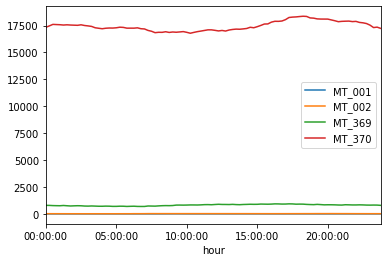

In [350]:
# Pre-normalization
average_curves[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

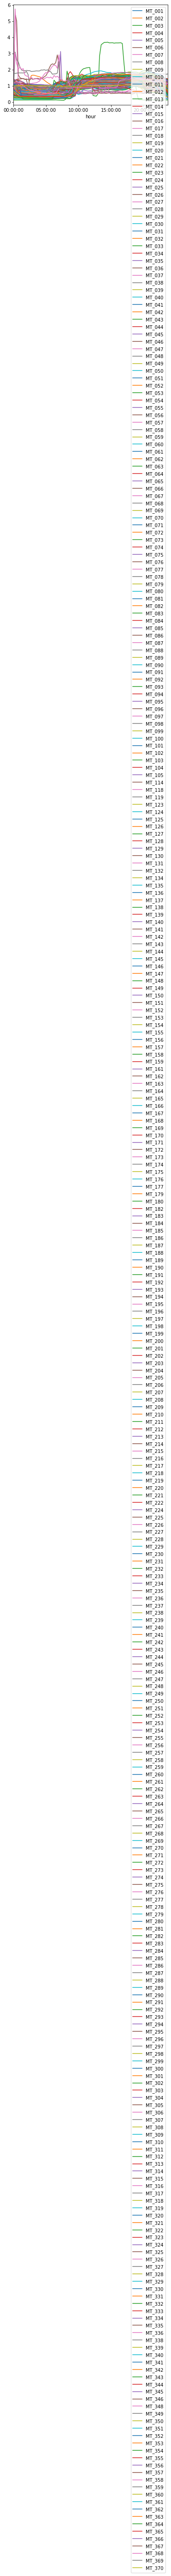

In [351]:
#average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
average_curves_norm.plot()
plt.show()

## Clustering Analysis on the average normalized curves

In [352]:
np.shape(average_curves_norm)

(96, 349)

In [353]:
X = average_curves_norm.copy()  # We call this normalized curve
X = np.array(X.T) # put it on the right format (transposed)
np.shape(X)  # Rows are for the clients, columns are for times

(349, 96)

# Questions (15 marks total)

**Q1: (7 marks)**

a. Determine what a convenient number of clusters. Justify your choice.  Make use of the sklearn's package for k-means for this. You may refer to the module to figure out how to come up with the optimal number of clusters. 

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the center of the cluster (make this curve thicker to distinguish it from the individual curves).  The center is also sometimes referred to as "centroid".
    
You have 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

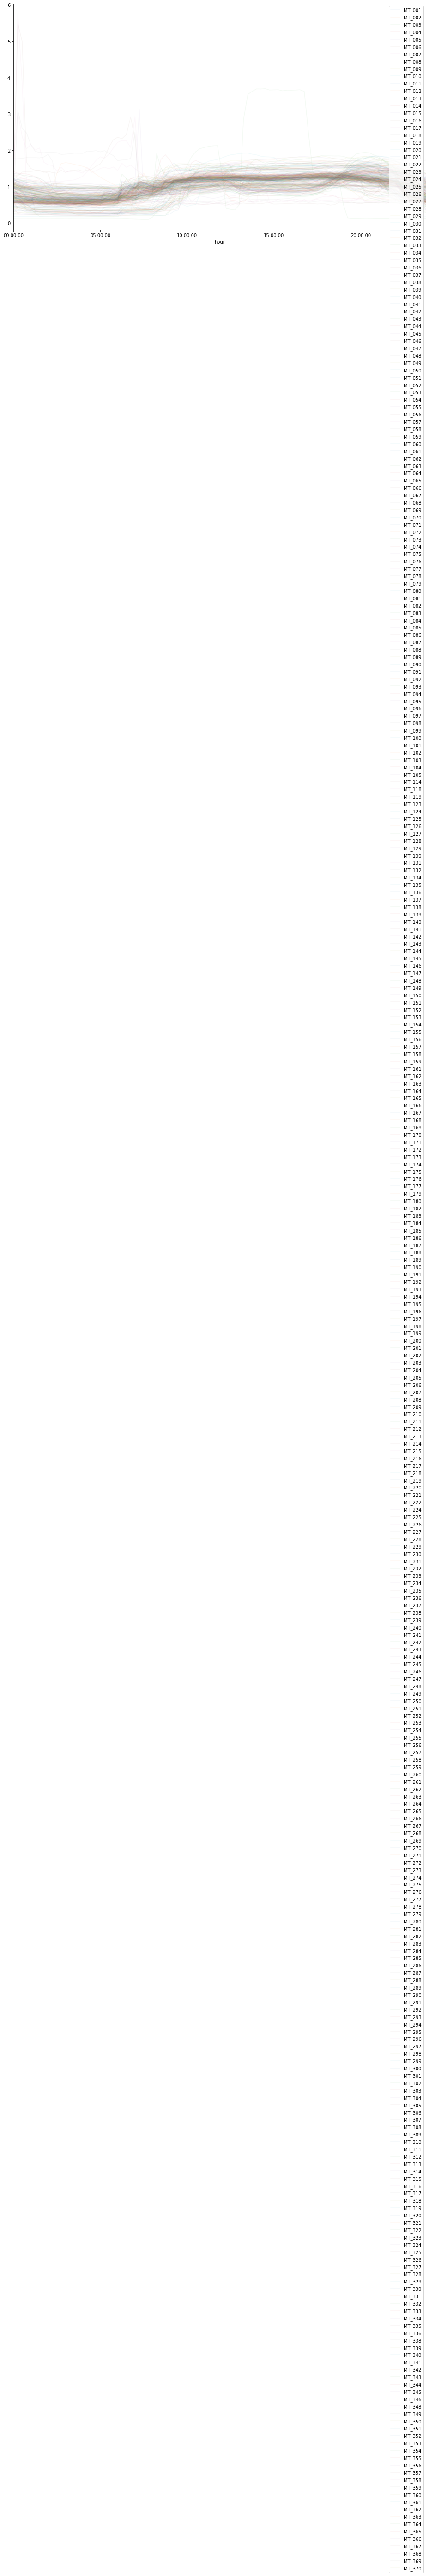

In [354]:
# Check the same plot of the above distribution, but with an alpha feature active that shows density distributions
average_curves_norm.plot(figsize=(16,9), legend=True, alpha=0.05)


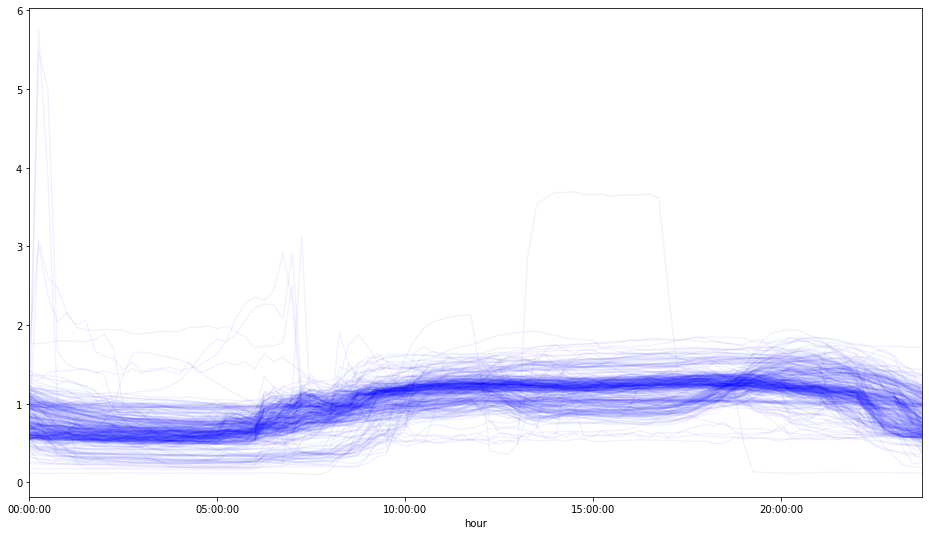

In [355]:
# set all curves to the same colour and remove legend to increase readibility 
average_curves_norm.plot(figsize=(16,9), legend=False,color = 'blue', alpha=0.05)


We can see that there are numerous outlier curves at different hours (night-time has spikes approaching a normalized value of 6, the afternoon has one spike with a normalized value of 4). 
The plot shows us (though the alpha option) that there is a significant density of curves that follows the typical energy consumption pattern of:
    - lower power usage at night
    - higher during the day

We essentially want to generate "curve-centroids" that will act as clusters for all the curves in our dataset.

There are two methods that can be used to evaluate the clusters -> Inertia rating and Silhouette Coefficient.

For N-d datasets such as this one, it may be preferential to use Silhouette Coefficents. I will derive the relationship between number of clusters and Silhoutte rating for the dataset, as follows:

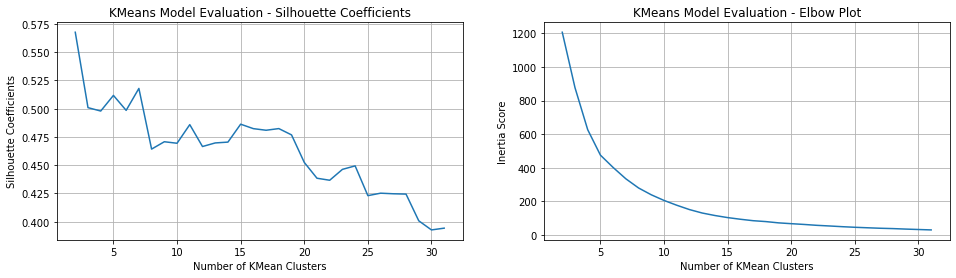

In [394]:
nClusterVals = np.linspace(2,31,30,dtype='int')  # Check 2 to 30 clusters (an obscenely high amount, but useful for demonstative purposes...)
silArray = []
inerArray = []
for i in nClusterVals:
    y_pred = KMeans(n_clusters = i,n_init = 100).fit(average_curves_norm)
    # Derive the silhouette scores using the sklearn metrics library
    silArray.append(silhouette_score(average_curves_norm,y_pred.labels_, metric='euclidean'))
    
    # Derive the sum of squared errors within each cluster for all the values of K
 


    
    inerArray.append(y_pred.inertia_)

fig, ax = plt.subplots(1,2,squeeze=False,figsize=(16,4))
ax[0][0].plot(nClusterVals,silArray)
ax[0][0].set_title("KMeans Model Evaluation - Silhouette Coefficients")
ax[0][0].set_xlabel("Number of KMean Clusters")
ax[0][0].set_ylabel("Silhouette Coefficients")
ax[0][0].grid()

ax[0][1].plot(nClusterVals,inerArray)
ax[0][1].set_title("KMeans Model Evaluation - Elbow Plot")
ax[0][1].set_xlabel("Number of KMean Clusters")
ax[0][1].set_ylabel("Inertia Score")
ax[0][1].grid()

Based on the plots above, we can see that as the number of Kmean clusters increases, the average Silhouette Coefficient and Inertia score decrease.  

Higher Silhouette scores indicate that the curves are placed in the correct clusters; the global maximum for the silhouette score shall be at the optimal number of clusters, which is K = 2 in this dataset.

The Elbow plot shows the sum of squared errors for each number of Kmean clusters. As the number of clusters increases, the squared errors between the actual curves and the centroid curves becomes smaller (as there are more clusters to select from, each curve is placed closer as a result). 

Based on the Silhouette Score, we should choose K = 2 as our optimal number of clusters. Based on the Elbow Plot, it can be argued that K = 5 may be the optimal number of clusters (this is where the rate of change bends noticeably). 

Let's investigate both to see how they fit to the data we have.



I will analyze the dataset using 2 clusters to start:

In [395]:
average_curves_norm_transposed = average_curves_norm.T 
# transpose the data; we want to create a new column that will have the cluster # associated with each accounts curve.

In [396]:
y_pred = KMeans(n_clusters = 2).fit_predict(average_curves_norm_transposed)

In [397]:
len(y_pred)

349

In [398]:
y_pred # This is the array of assumed clusterings for the 349 accounts in our dataset

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [399]:
y_pred_sr = pd.Series(y_pred, name='cluster')
average_curves_norm_updated = average_curves_norm_transposed.set_index(y_pred_sr, append=True )
# create a new copy of the dataset, with the cluster column for each account


In [400]:
average_curves_norm_updated

hour            00:00:00  00:15:00  00:30:00  00:45:00  01:00:00  01:15:00  \
       cluster                                                               
MT_001 1        0.964792  0.947378  0.960104  0.959434  0.956085  0.972494   
MT_002 1        0.926674  0.919117  0.880744  0.877243  0.841989  0.806701   
MT_003 1        0.991800  0.977796  0.976579  0.971708  0.953443  0.949181   
MT_004 1        1.140106  1.099159  1.061641  1.030153  0.975761  0.920906   
MT_005 1        1.186498  1.131703  1.090238  1.053960  1.024347  0.992994   
...                  ...       ...       ...       ...       ...       ...   
MT_366 1        1.358632  1.365299  1.312627  1.245171  1.292298  1.246425   
MT_367 1        1.215272  1.184899  1.177781  1.156699  1.149629  1.139513   
MT_368 1        1.170441  1.223818  1.211343  1.189829  1.167326  1.105127   
MT_369 1        0.974307  0.969266  0.947969  0.937889  0.931284  0.959546   
MT_370 1        0.992967  1.000548  1.008515  1.007613  1.006770  1.005071   

hour            01:30:00  01:45:00  02:00:00  02:15:00  ...  21:30:00  \
       cluster                                          ...             
MT_001 1        0.970485  0.983211  0.965127  0.965127  ...  1.030429   
MT_002 1        0.786076  0.778034  0.759108  0.763579  ...  1.095834   
MT_003 1        0.954660  0.947354  0.918739  0.925436  ...  1.111741   
MT_004 1        0.897345  0.875850  0.855450  0.836217  ...  1.502958   
MT_005 1        0.962757  0.934785  0.918994  0.903958  ...  1.366081   
...                  ...       ...       ...       ...  ...       ...   
MT_366 1        1.221937  1.160817  1.096199  0.922938  ...  1.361140   
MT_367 1        1.125489  1.092430  1.069030  1.043176  ...  1.002055   
MT_368 1        0.993529  0.914299  0.842847  0.789775  ...  1.298331   
MT_369 1        0.929746  0.903852  0.920795  0.933955  ...  1.033427   
MT_370 1        1.006327  1.005100  1.004361  1.003668  ...  1.026038   

hour            21:45:00  22:00:00  22:15:00  22:30:00  22:45:00  23:00:00  \
       cluster                                                               
MT_001 1        1.049852  1.022727  0.973164  0.994931  0.996941  1.024736   
MT_002 1        1.049731  1.005708  1.005500  0.979363  0.955618  0.957767   
MT_003 1        1.101391  1.092867  1.081908  1.069122  1.038072  1.009456   
MT_004 1        1.495640  1.462960  1.422622  1.389845  1.347294  1.293558   
MT_005 1        1.376127  1.382463  1.388340  1.385878  1.369364  1.352292   
...                  ...       ...       ...       ...       ...       ...   
MT_366 1        1.352362  1.356124  1.300020  1.358302  1.417178  1.406155   
MT_367 1        1.014598  1.021865  1.182977  1.273484  1.265394  1.268087   
MT_368 1        1.280347  1.264828  1.242055  1.223890  1.204952  1.186229   
MT_369 1        1.020555  1.020748  1.032500  1.023658  1.005845  1.000981   
MT_370 1        1.023395  1.024567  1.019028  1.016896  1.013001  1.004462   

hour            23:15:00  23:30:00  23:45:00  
       cluster                                
MT_001 1        1.031768  1.006652  1.001629  
MT_002 1        0.954925  0.923346  0.926570  
MT_003 1        1.003976  0.998497  0.993017  
MT_004 1        1.238946  1.209744  1.175290  
MT_005 1        1.324550  1.272842  1.231541  
...                  ...       ...       ...  
MT_366 1        1.393548  1.360414  1.324442  
MT_367 1        1.252350  1.247264  1.227273  
MT_368 1        1.174311  1.153788  1.136380  
MT_369 1        1.008670  1.003680  0.974611  
MT_370 1        0.991657  0.993947  0.987431  

[349 rows x 96 columns]

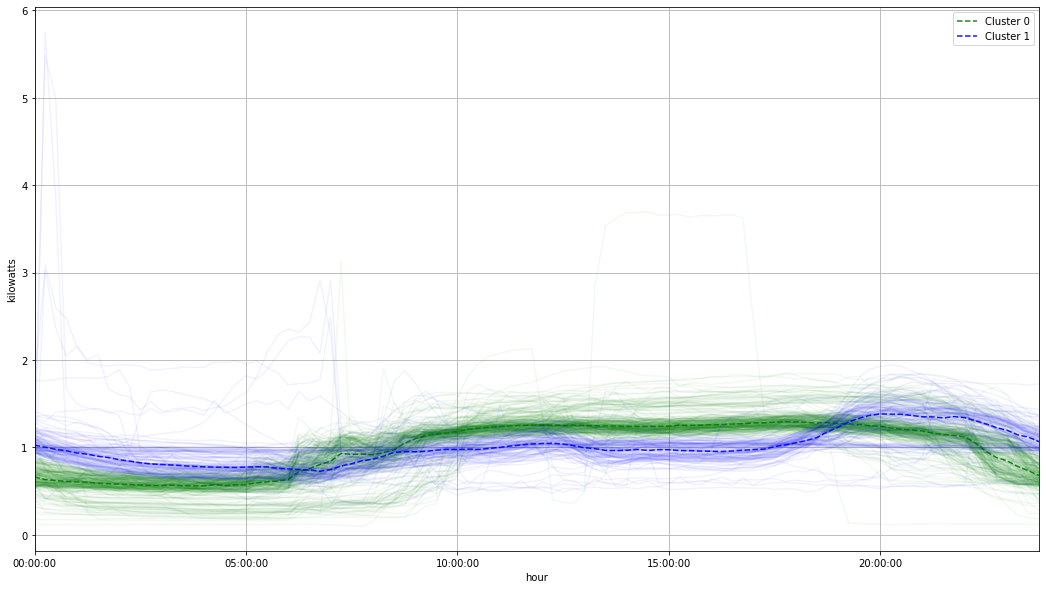

In [401]:
# Plot the results
# All accounts over the course of a day,
# and subsequently the "centroid" curves overlaying them

fig, ax= plt.subplots(1,1, figsize=(18,10))

cluster_values = sorted(average_curves_norm_updated.index.get_level_values('cluster').unique())
color_list = ['green','blue','red','magenta','orange','brown','purple','yellow','black','pink']

for cluster, color in zip(cluster_values, color_list):
    average_curves_norm_updated.xs(cluster, level=1).T.plot(ax=ax,legend=False, alpha=0.05, color=color)
    average_curves_norm_updated.xs(cluster, level=1).median().plot(ax=ax,legend=True,color=color, alpha=0.9, ls='--',label= f'Cluster {cluster}')

ax.set_ylabel('kilowatts')
ax.set_xlabel('hour')
ax.grid()

In [402]:
y_pred_sr.value_counts()

0    236
1    113
Name: cluster, dtype: int64

We can see from the plot above that using K = 2, we find 2 distinct curve densities around our "centroid" curves (in dashed lines). These do not consider the outliers, such as the spike near 1AM, or the large base-load in the afternoon.

Investigating K = 5:

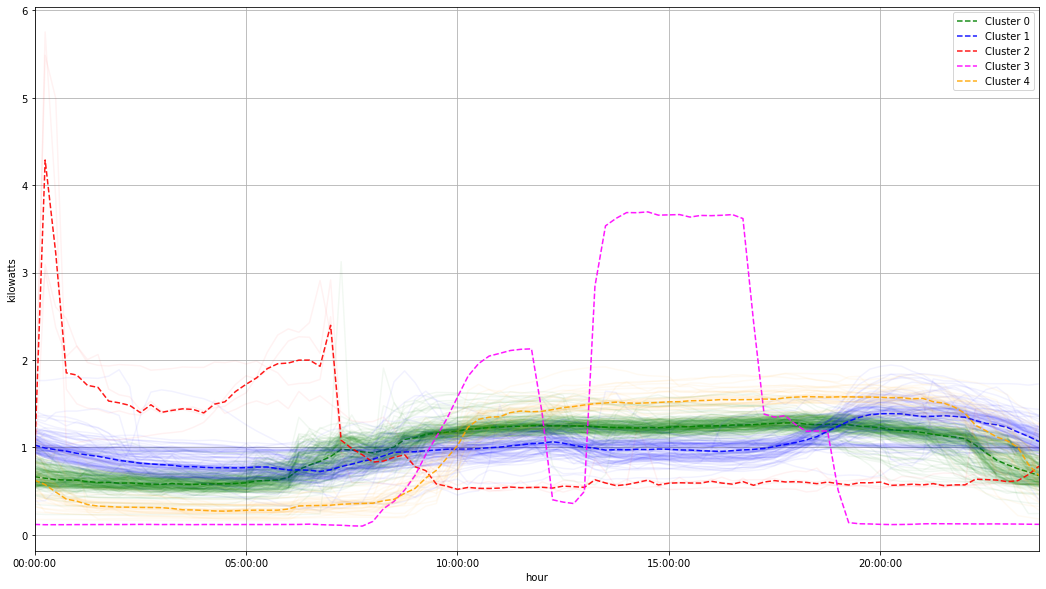

In [403]:
y_pred = KMeans(n_clusters = 5).fit_predict(average_curves_norm_transposed)
y_pred_sr = pd.Series(y_pred, name='cluster')
average_curves_norm_updated = average_curves_norm_transposed.set_index(y_pred_sr, append=True )
fig, ax= plt.subplots(1,1, figsize=(18,10))

cluster_values = sorted(average_curves_norm_updated.index.get_level_values('cluster').unique())
color_list = ['green','blue','red','magenta','orange','brown','purple','yellow','black','pink']

for cluster, color in zip(cluster_values, color_list):
    average_curves_norm_updated.xs(cluster, level=1).T.plot(ax=ax,legend=False, alpha=0.05, color=color)
    average_curves_norm_updated.xs(cluster, level=1).median().plot(ax=ax,legend=True,color=color, alpha=0.9, ls='--',label= f'Cluster {cluster}')

ax.set_ylabel('kilowatts')
ax.set_xlabel('hour')
ax.grid()

From the plot above, we can see that using 10 clusters increases our coverage to include the outliers I had previously mentioned; the midnight spike (magenta) and afternoon constant load (pink). 

However, the majority of these clusters are thin in terms of curve coverage. Investigating the distribution:

In [404]:
y_pred_sr.value_counts()

0    201
1    109
4     34
2      4
3      1
Name: cluster, dtype: int64

In [405]:
y_pred_sr.value_counts()/len(y_pred_sr)

0    0.575931
1    0.312321
4    0.097421
2    0.011461
3    0.002865
Name: cluster, dtype: float64

More than 95% of the account curves fall within Clusters 0 (Green), 2 (Red), and 1 (Blue). Clusters 3 (Magenta) and 4 (Orange) cover the outlier cases, but these have very few account curves associated with them, relative to the entire dataset population; we can assume these are outliers and focus on the main high-density clusters. 



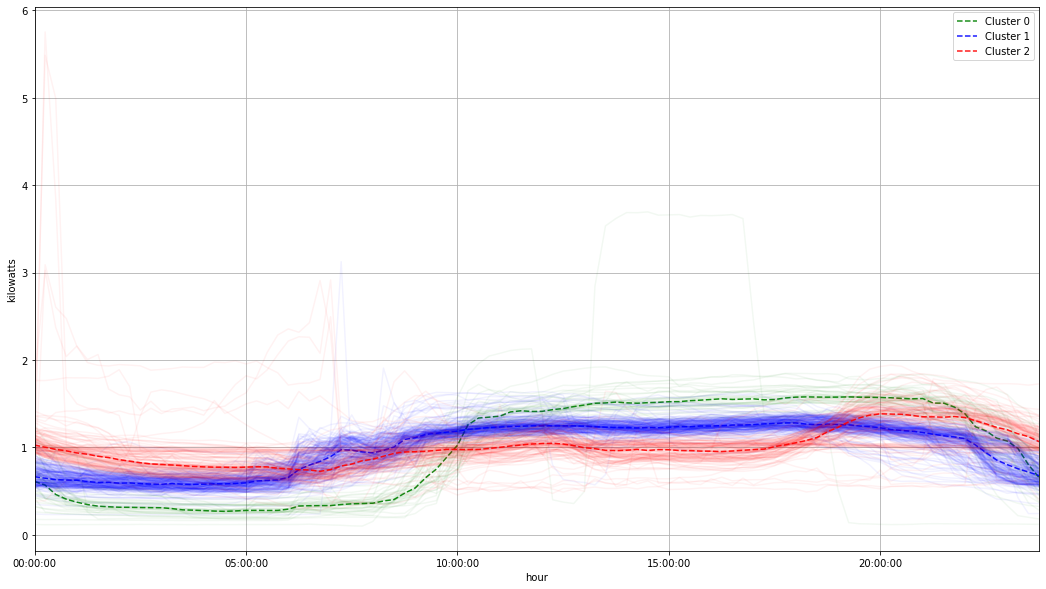

In [406]:
y_pred = KMeans(n_clusters = 3).fit_predict(average_curves_norm_transposed)
y_pred_sr = pd.Series(y_pred, name='cluster')
average_curves_norm_updated = average_curves_norm_transposed.set_index(y_pred_sr, append=True )
fig, ax= plt.subplots(1,1, figsize=(18,10))

cluster_values = sorted(average_curves_norm_updated.index.get_level_values('cluster').unique())
color_list = ['green','blue','red','magenta','orange','brown','purple','yellow','black','pink']

for cluster, color in zip(cluster_values, color_list):
    average_curves_norm_updated.xs(cluster, level=1).T.plot(ax=ax,legend=False, alpha=0.05, color=color)
    average_curves_norm_updated.xs(cluster, level=1).median().plot(ax=ax,legend=True,color=color, alpha=0.9, ls='--',label= f'Cluster {cluster}')

ax.set_ylabel('kilowatts')
ax.set_xlabel('hour')
ax.grid()

Analyzing the data once more for K = 3 clusters, we notice three similar trends in the data which can point to 3 different usage profiles. Recalling that we normalized the kilowatts data (by dividing by each account's mean daily value), we are seeing the relative rate of change in usage per hour. From midnight to the early morning hours we see very little usage, while there is an increased usage during working hours.

The number of curves per cluster is as follows:

In [407]:
y_pred_sr.value_counts()

1    201
2    113
0     35
Name: cluster, dtype: int64

We can plot these clusters separately and show the labelling of each account associated with them:

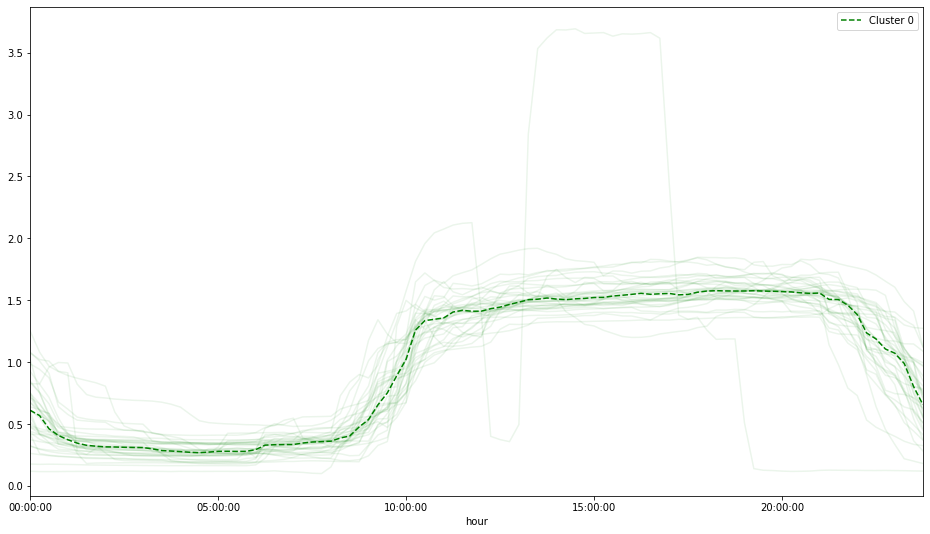

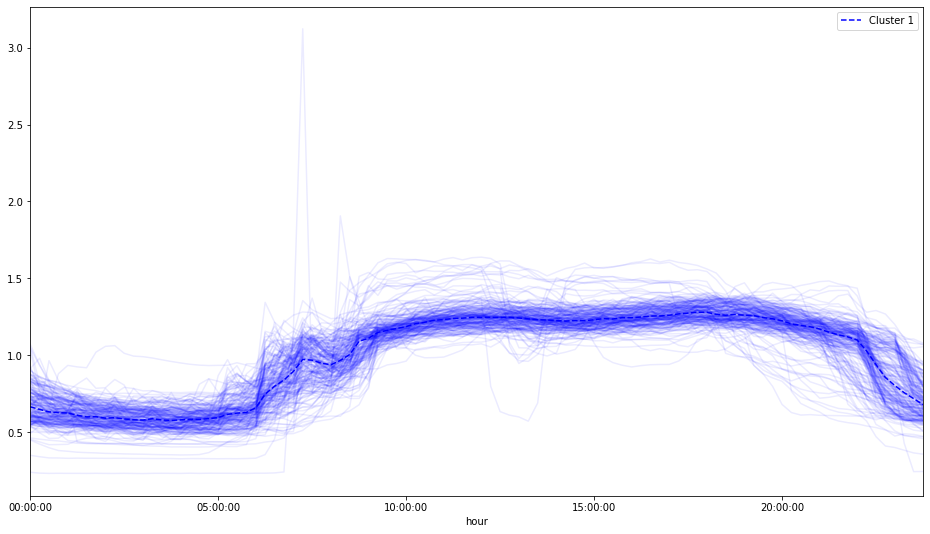

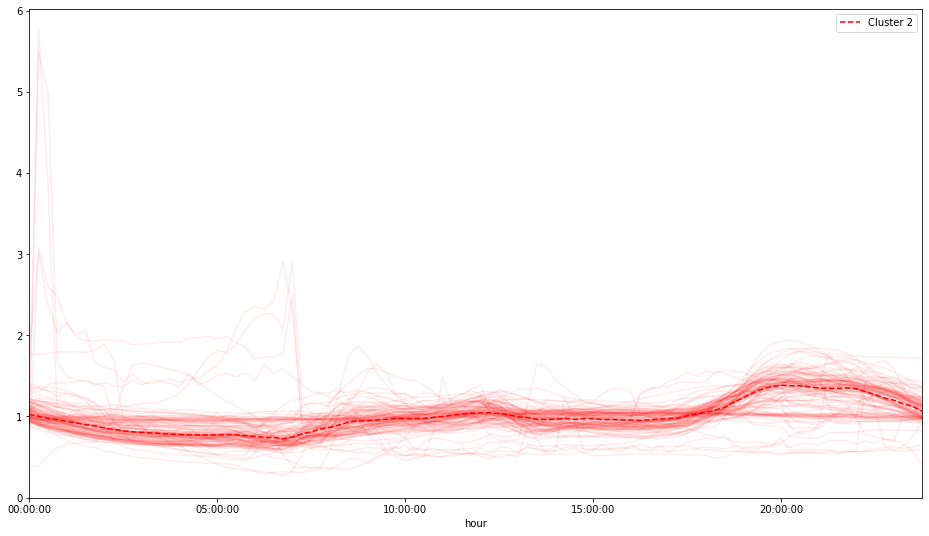

In [416]:
cluster_values = sorted(average_curves_norm_updated.index.get_level_values('cluster').unique())
color_list = ['green','blue','red','magenta','orange','brown','purple','yellow','black','pink']

for cluster, color in zip(cluster_values, color_list):
    average_curves_norm_updated.xs(cluster, level=1).T.plot(figsize =(16,9),legend=False, alpha=0.08, color=color)
    average_curves_norm_updated.xs(cluster, level=1).median().plot(legend=True,color=color, alpha=1, ls='--',label= f'Cluster {cluster}')


In [434]:
# Print out the list of accounts belonging to each cluster
print("Accounts belonging to Cluster 0",average_curves_norm_updated.xs(0, level=1).index.values)
print("Accounts belonging to Cluster 1",average_curves_norm_updated.xs(1, level=1).index.values)
print("Accounts belonging to Cluster 2",average_curves_norm_updated.xs(2, level=1).index.values)


Accounts belonging to Cluster 0 ['MT_093' 'MT_098' 'MT_099' 'MT_100' 'MT_101' 'MT_103' 'MT_104' 'MT_105'
 'MT_125' 'MT_334' 'MT_335' 'MT_339' 'MT_340' 'MT_341' 'MT_342' 'MT_343'
 'MT_344' 'MT_345' 'MT_346' 'MT_349' 'MT_350' 'MT_351' 'MT_352' 'MT_353'
 'MT_354' 'MT_355' 'MT_356' 'MT_357' 'MT_358' 'MT_360' 'MT_361' 'MT_362'
 'MT_363' 'MT_364' 'MT_365']
Accounts belonging to Cluster 1 ['MT_012' 'MT_013' 'MT_014' 'MT_015' 'MT_022' 'MT_036' 'MT_038' 'MT_045'
 'MT_050' 'MT_064' 'MT_077' 'MT_084' 'MT_091' 'MT_092' 'MT_095' 'MT_096'
 'MT_097' 'MT_118' 'MT_123' 'MT_126' 'MT_128' 'MT_134' 'MT_135' 'MT_136'
 'MT_137' 'MT_138' 'MT_139' 'MT_140' 'MT_151' 'MT_153' 'MT_155' 'MT_156'
 'MT_165' 'MT_166' 'MT_167' 'MT_168' 'MT_169' 'MT_170' 'MT_171' 'MT_172'
 'MT_173' 'MT_174' 'MT_175' 'MT_176' 'MT_177' 'MT_179' 'MT_180' 'MT_182'
 'MT_183' 'MT_184' 'MT_185' 'MT_186' 'MT_187' 'MT_188' 'MT_189' 'MT_190'
 'MT_191' 'MT_192' 'MT_193' 'MT_194' 'MT_195' 'MT_196' 'MT_197' 'MT_198'
 'MT_199' 'MT_200' 'MT_201' 'MT

**Q2: (8 marks)**

In this exercise you work with the daily curves of 1 single client.
First, create a list of arrays, each array containing a curve for a day. You may use X from the cells above (below).
    X = average_curves_norm.copy() 
The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value of k ( number of clusters). This time you may also perform silhoutte analysis as stated in the module. Carrying out silhoutte analysis is left as an exercise. What do you understand about the clusters? 

b. Based on your results from your analyses of both methods, what do understand?  Interpret it perhaps with different perspectives of timelines like weeks or months.

In [435]:
# This is for Q2 - generates an list X that contains all the daily curves for the client from 2013 and 2014



client = 'MT_022'
oneClient = data_13_14[client]
print(oneClient)
oneClient.size
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

2013-01-01 00:15:00    31.133250
2013-01-01 00:30:00    28.642590
2013-01-01 00:45:00    27.397260
2013-01-01 01:00:00    24.906600
2013-01-01 01:15:00    24.283935
                         ...    
2014-12-31 23:00:00    31.133250
2014-12-31 23:15:00    34.246575
2014-12-31 23:30:00    36.114570
2014-12-31 23:45:00    34.246575
2015-01-01 00:00:00    31.133250
Name: MT_022, Length: 70080, dtype: float64


In [436]:
np.shape(X)
# 730 days (rows), 96 time stamps at 15 minute intervals (columns)

(730, 96)

In [437]:
X

[array([31.13325031, 28.64259029, 27.39726027, 24.90660025, 24.28393524,
        26.15193026, 26.15193026, 24.90660025, 26.77459527, 23.66127024,
        23.66127024, 21.17061021, 23.03860523, 19.30261519, 18.67995019,
        18.67995019, 19.30261519, 19.30261519, 18.67995019, 19.30261519,
        18.05728518, 18.05728518, 17.43462017, 16.81195517, 17.43462017,
        17.43462017, 17.43462017, 17.43462017, 18.67995019, 21.17061021,
        19.30261519, 20.54794521, 19.9252802 , 21.17061021, 20.54794521,
        21.79327522, 24.90660025, 31.13325031, 23.66127024, 19.30261519,
        21.79327522, 20.54794521, 13.69863014, 16.81195517, 15.56662516,
        18.05728518, 18.05728518, 16.81195517, 19.9252802 , 16.81195517,
        18.05728518, 20.54794521, 16.81195517, 18.67995019, 21.17061021,
        19.9252802 , 16.81195517, 16.18929016, 17.43462017, 18.05728518,
        18.67995019, 15.56662516, 18.05728518, 19.30261519, 18.05728518,
        15.56662516, 17.43462017, 18.05728518, 16.1

Lets first convert our list of arrays into a dataframe, then scrub the indices to show the hours and dates.

In [438]:
dfX = pd.DataFrame(X)
dfX.tail(5) # Columns are time intervals of 15min, rows are days 


0          1          2          3          4          5   \
725  21.170610  21.793275  21.170610  20.547945  21.793275  21.170610   
726  31.133250  29.265255  28.019925  28.019925  26.151930  24.906600   
727  28.642590  29.887920  27.397260  28.642590  26.774595  26.151930   
728  29.265255  29.887920  30.510585  28.642590  28.019925  27.397260   
729  24.906600  26.774595  23.661270  22.415940  22.415940  23.038605   

            6          7          8          9   ...         86         87  \
725  19.925280  19.925280  19.925280  19.302615  ...  37.982565  38.605230   
726  24.906600  25.529265  25.529265  25.529265  ...  39.850560  38.605230   
727  26.774595  26.151930  26.774595  25.529265  ...  36.114570  34.246575   
728  28.642590  27.397260  28.642590  26.774595  ...  32.378580  33.623910   
729  21.793275  21.793275  21.170610  22.415940  ...  34.869240  34.869240   

            88         89         90         91         92         93  \
725  36.114570  37.982565  37.359900  36.114570  37.359900  35.491905   
726  37.982565  32.378580  32.378580  29.887920  33.001245  33.623910   
727  31.755915  31.133250  33.001245  33.001245  36.114570  36.114570   
728  28.019925  25.529265  26.151930  27.397260  29.265255  29.887920   
729  32.378580  33.001245  32.378580  31.133250  34.246575  36.114570   

            94        95  
725  32.378580  28.64259  
726  29.887920  26.15193  
727  32.378580  29.88792  
728  24.283935  23.66127  
729  34.246575  31.13325  

[5 rows x 96 columns]

In [439]:
#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b).  
#The cells below are only to give you a headstart. 
#You may or may not use these and come up with your own interpretation.

from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

In [440]:
# Update the dataframe days indices with actual values, as per the code snippet above.
dfX_copy = dfX
dfX_copy['date'] = daysyear
dfX_copy.head(5)
dfX_copy.set_index("date", inplace = True)
dfX = dfX_copy

In [441]:
dfX.head(5)

0          1          2          3          4   \
date                                                                    
tue-2013-01-01  31.133250  28.642590  27.397260  24.906600  24.283935   
wed-2013-01-02  22.415940  22.415940  20.547945  20.547945  22.415940   
thu-2013-01-03  21.793275  21.170610  20.547945  19.925280  19.302615   
fri-2013-01-04  23.661270  22.415940  22.415940  21.793275  22.415940   
sat-2013-01-05  19.925280  19.302615  19.925280  19.302615  18.057285   

                       5          6          7          8          9   ...  \
date                                                                   ...   
tue-2013-01-01  26.151930  26.151930  24.906600  26.774595  23.661270  ...   
wed-2013-01-02  21.793275  19.925280  23.038605  20.547945  21.170610  ...   
thu-2013-01-03  20.547945  18.057285  18.679950  18.057285  17.434620  ...   
fri-2013-01-04  20.547945  21.170610  21.170610  21.793275  21.793275  ...   
sat-2013-01-05  18.679950  18.057285  18.057285  18.057285  19.302615  ...   

                       86         87         88         89         90  \
date                                                                    
tue-2013-01-01  31.133250  28.019925  26.774595  26.774595  24.906600   
wed-2013-01-02  29.265255  28.642590  26.774595  28.642590  26.774595   
thu-2013-01-03  31.755915  31.755915  32.378580  33.001245  29.265255   
fri-2013-01-04  30.510585  27.397260  28.019925  27.397260  28.019925   
sat-2013-01-05  33.623910  33.001245  27.397260  27.397260  30.510585   

                       91         92         93         94         95  
date                                                                   
tue-2013-01-01  26.151930  27.397260  26.774595  23.661270  24.283935  
wed-2013-01-02  24.906600  23.038605  23.038605  23.661270  24.283935  
thu-2013-01-03  26.774595  28.019925  26.774595  28.019925  26.151930  
fri-2013-01-04  26.774595  29.887920  28.642590  26.774595  24.906600  
sat-2013-01-05  29.265255  29.887920  30.510585  26.151930  28.019925  

[5 rows x 96 columns]

In [442]:
  # create a new column specifically for the time 
data_13_14['hour'] = data_13_14.index.map(lambda x: x[11:])
hoursCol = (data_13_14['hour'].unique())

In [443]:
# Update the dataframe time segment indices with actual values (15 minute intervals), as per the code snippet above

dfX_copy = dfX.T
dfX_copy['hour'] = hoursCol
dfX_copy
dfX_copy.set_index("hour", inplace = True)
dfX_copy

date      tue-2013-01-01  wed-2013-01-02  thu-2013-01-03  fri-2013-01-04  \
hour                                                                       
00:15:00       31.133250       22.415940       21.793275       23.661270   
00:30:00       28.642590       22.415940       21.170610       22.415940   
00:45:00       27.397260       20.547945       20.547945       22.415940   
01:00:00       24.906600       20.547945       19.925280       21.793275   
01:15:00       24.283935       22.415940       19.302615       22.415940   
...                  ...             ...             ...             ...   
23:00:00       26.151930       24.906600       26.774595       26.774595   
23:15:00       27.397260       23.038605       28.019925       29.887920   
23:30:00       26.774595       23.038605       26.774595       28.642590   
23:45:00       23.661270       23.661270       28.019925       26.774595   
00:00:00       24.283935       24.283935       26.151930       24.906600   

date      sat-2013-01-05  sun-2013-01-06  mon-2013-01-07  tue-2013-01-08  \
hour                                                                       
00:15:00       19.925280       27.397260       21.793275       23.038605   
00:30:00       19.302615       25.529265       21.793275       24.283935   
00:45:00       19.925280       24.283935       21.793275       21.170610   
01:00:00       19.302615       23.661270       21.170610       21.170610   
01:15:00       18.057285       23.038605       20.547945       19.302615   
...                  ...             ...             ...             ...   
23:00:00       29.265255       26.151930       23.661270       24.283935   
23:15:00       29.887920       24.283935       23.038605       25.529265   
23:30:00       30.510585       25.529265       22.415940       24.283935   
23:45:00       26.151930       24.283935       22.415940       25.529265   
00:00:00       28.019925       24.906600       21.170610       22.415940   

date      wed-2013-01-09  thu-2013-01-10  ...  mon-2014-12-22  tue-2014-12-23  \
hour                                      ...                                   
00:15:00       21.170610       21.793275  ...       29.887920       26.774595   
00:30:00       22.415940       19.302615  ...       28.019925       28.019925   
00:45:00       21.170610       19.302615  ...       25.529265       25.529265   
01:00:00       19.302615       18.057285  ...       24.283935       24.906600   
01:15:00       17.434620       16.811955  ...       24.283935       24.283935   
...                  ...             ...  ...             ...             ...   
23:00:00       25.529265       25.529265  ...       28.019925       24.906600   
23:15:00       26.774595       26.151930  ...       33.001245       30.510585   
23:30:00       27.397260       23.038605  ...       30.510585       31.133250   
23:45:00       24.283935       24.906600  ...       28.019925       28.642590   
00:00:00       23.661270       23.661270  ...       26.151930       24.906600   

date      wed-2014-12-24  thu-2014-12-25  fri-2014-12-26  sat-2014-12-27  \
hour                                                                       
00:15:00       25.529265       25.529265       23.661270       21.170610   
00:30:00       24.906600       25.529265       23.038605       21.793275   
00:45:00       23.038605       26.151930       23.038605       21.170610   
01:00:00       24.283935       28.019925       23.038605       20.547945   
01:15:00       23.038605       25.529265       23.038605       21.793275   
...                  ...             ...             ...             ...   
23:00:00       29.265255       29.265255       28.642590       36.114570   
23:15:00       34.869240       33.623910       33.001245       37.359900   
23:30:00       31.755915       35.491905       31.133250       35.491905   
23:45:00       26.774595       26.774595       29.887920       32.378580   
00:00:00       24.906600       24.906600       25.529265

In [444]:
dfX = dfX_copy.T
dfX.head(5)

hour             00:15:00   00:30:00   00:45:00   01:00:00   01:15:00  \
date                                                                    
tue-2013-01-01  31.133250  28.642590  27.397260  24.906600  24.283935   
wed-2013-01-02  22.415940  22.415940  20.547945  20.547945  22.415940   
thu-2013-01-03  21.793275  21.170610  20.547945  19.925280  19.302615   
fri-2013-01-04  23.661270  22.415940  22.415940  21.793275  22.415940   
sat-2013-01-05  19.925280  19.302615  19.925280  19.302615  18.057285   

hour             01:30:00   01:45:00   02:00:00   02:15:00   02:30:00  ...  \
date                                                                   ...   
tue-2013-01-01  26.151930  26.151930  24.906600  26.774595  23.661270  ...   
wed-2013-01-02  21.793275  19.925280  23.038605  20.547945  21.170610  ...   
thu-2013-01-03  20.547945  18.057285  18.679950  18.057285  17.434620  ...   
fri-2013-01-04  20.547945  21.170610  21.170610  21.793275  21.793275  ...   
sat-2013-01-05  18.679950  18.057285  18.057285  18.057285  19.302615  ...   

hour             21:45:00   22:00:00   22:15:00   22:30:00   22:45:00  \
date                                                                    
tue-2013-01-01  31.133250  28.019925  26.774595  26.774595  24.906600   
wed-2013-01-02  29.265255  28.642590  26.774595  28.642590  26.774595   
thu-2013-01-03  31.755915  31.755915  32.378580  33.001245  29.265255   
fri-2013-01-04  30.510585  27.397260  28.019925  27.397260  28.019925   
sat-2013-01-05  33.623910  33.001245  27.397260  27.397260  30.510585   

hour             23:00:00   23:15:00   23:30:00   23:45:00   00:00:00  
date                                                                   
tue-2013-01-01  26.151930  27.397260  26.774595  23.661270  24.283935  
wed-2013-01-02  24.906600  23.038605  23.038605  23.661270  24.283935  
thu-2013-01-03  26.774595  28.019925  26.774595  28.019925  26.151930  
fri-2013-01-04  26.774595  29.887920  28.642590  26.774595  24.906600  
sat-2013-01-05  29.265255  29.887920  30.510585  26.151930  28.019925  

[5 rows x 96 columns]

Now our dataframe has been cleaned and is ready for analysis. Let's plot the data for the client like we did in Part 1 to see what the distribution looks like throughout both years. 

Text(0, 0.5, 'kW')

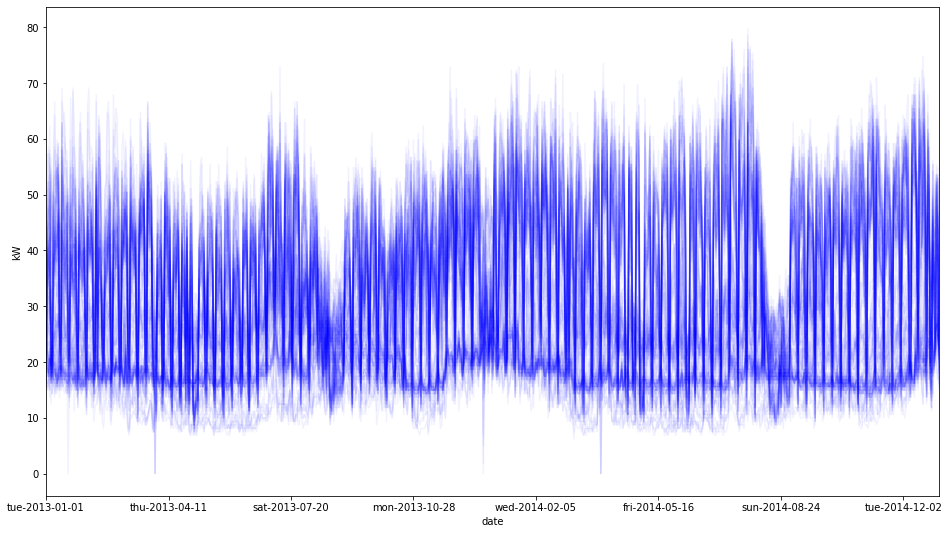

In [445]:
dfX.plot(figsize=(16,9), legend=False,color = 'blue', alpha=0.05)
plt.ylabel('kW')

The above plot shows the curves spanning 2013 and 2014, with KW on the y-axis. This essentially shows us the stacking of curves representing each time segment, showing the average kWh value (y-axis) for that time (curve), on that day (x-axis). This can be better visualized below when the colours are automatically set per curve.


Text(0, 0.5, 'kW')

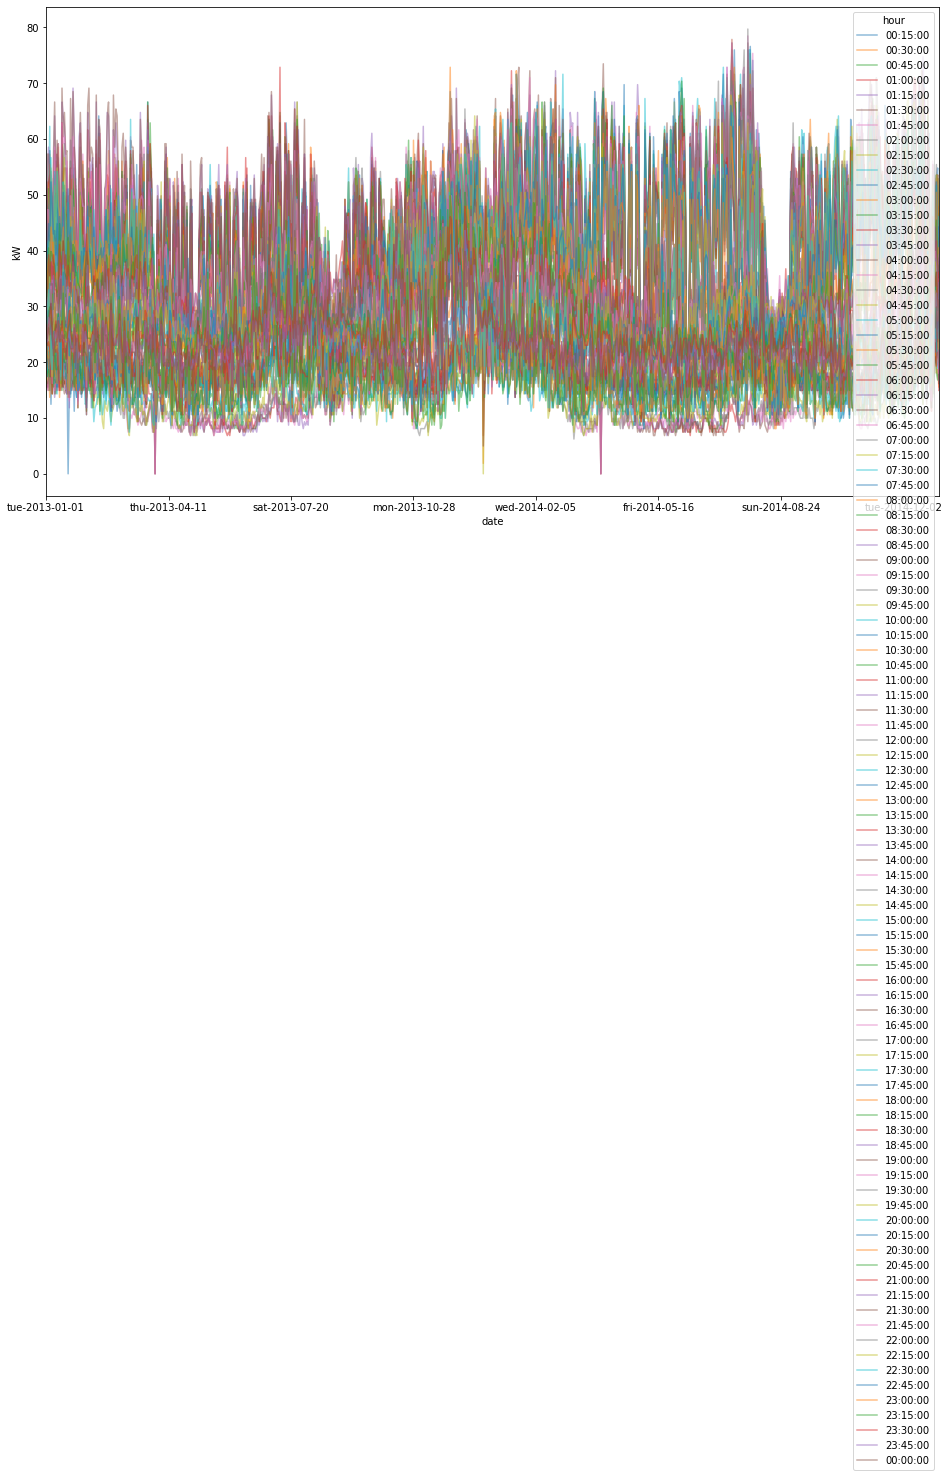

In [446]:
dfX.plot(figsize=(16,9), legend=True, alpha=0.5)
plt.ylabel('kW')

This dataset  can tell us what the kW values are at specific times across the entire 2013-2014 range. Note that the data looks extremely noisy at first glance, but perhaps clustering the data will show some trends. An attempt to derive an optimal amount of clusters will be made using the Silhouette scoring criteria as follows:

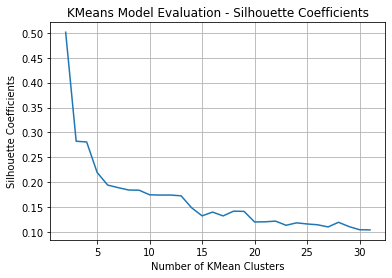

In [447]:

nClusterVals = np.linspace(2,31,30,dtype='int')  # Check 2 to 30 clusters (an obscenely high amount, but useful for demonstative purposes...)
silArray = []
for i in nClusterVals:
    y_pred = KMeans(n_clusters = i,n_init = 100).fit(dfX)
    # Derive the silhouette scores using the sklearn metrics library
    silArray.append(silhouette_score(dfX,y_pred.labels_, metric='euclidean'))

plt.plot(nClusterVals,silArray)
plt.title("KMeans Model Evaluation - Silhouette Coefficients")
plt.xlabel("Number of KMean Clusters")
plt.ylabel("Silhouette Coefficients")
plt.grid()

Based on the Silhouette Scores, we can see that as you increase the number of Kmean clusters, the clustering accuracy decreases. Investigating what a clustering of K = 2 looks like with the data:
    

In [448]:
dfX_updated = dfX.T
y_pred = KMeans(n_clusters = 2).fit_predict(dfX_updated)
y_pred_sr = pd.Series(y_pred, name='cluster')
print(y_pred)
dfX_updated = dfX_updated.set_index(y_pred_sr, append=True )
dfX_updated.tail(5)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


date              tue-2013-01-01  wed-2013-01-02  thu-2013-01-03  \
hour     cluster                                                   
23:00:00 0             26.151930       24.906600       26.774595   
23:15:00 0             27.397260       23.038605       28.019925   
23:30:00 0             26.774595       23.038605       26.774595   
23:45:00 0             23.661270       23.661270       28.019925   
00:00:00 0             24.283935       24.283935       26.151930   

date              fri-2013-01-04  sat-2013-01-05  sun-2013-01-06  \
hour     cluster                                                   
23:00:00 0             26.774595       29.265255       26.151930   
23:15:00 0             29.887920       29.887920       24.283935   
23:30:00 0             28.642590       30.510585       25.529265   
23:45:00 0             26.774595       26.151930       24.283935   
00:00:00 0             24.906600       28.019925       24.906600   

date              mon-2013-01-07  tue-2013-01-08  wed-2013-01-09  \
hour     cluster                                                   
23:00:00 0             23.661270       24.283935       25.529265   
23:15:00 0             23.038605       25.529265       26.774595   
23:30:00 0             22.415940       24.283935       27.397260   
23:45:00 0             22.415940       25.529265       24.283935   
00:00:00 0             21.170610       22.415940       23.661270   

date              thu-2013-01-10  ...  mon-2014-12-22  tue-2014-12-23  \
hour     cluster                  ...                                   
23:00:00 0             25.529265  ...       28.019925       24.906600   
23:15:00 0             26.151930  ...       33.001245       30.510585   
23:30:00 0             23.038605  ...       30.510585       31.133250   
23:45:00 0             24.906600  ...       28.019925       28.642590   
00:00:00 0             23.661270  ...       26.151930       24.906600   

date              wed-2014-12-24  thu-2014-12-25  fri-2014-12-26  \
hour     cluster                                                   
23:00:00 0             29.265255       29.265255       28.642590   
23:15:00 0             34.869240       33.623910       33.001245   
23:30:00 0             31.755915       35.491905       31.133250   
23:45:00 0             26.774595       26.774595       29.887920   
00:00:00 0             24.906600       24.906600       25.529265   

date              sat-2014-12-27  sun-2014-12-28  mon-2014-12-29  \
hour     cluster                                                   
23:00:00 0             36.114570       29.887920       33.001245   
23:15:00 0             37.359900       33.001245       36.114570   
23:30:00 0             35.491905       33.623910       36.114570   
23:45:00 0             32.378580       29.887920       32.378580   
00:00:00 0             28.642590       26.151930       29.887920   

date              tue-2014-12-30  wed-2014-12-31  
hour     cluster                                  
23:00:00 0             27.397260       31.133250  
23:15:00 0             29.265255       34.246575  
23:30:00 0             29.887920       36.114570  
23:45:00 0             24.283935       34.246575  
00:00:00 0             23.661270       31.133250  

[5 rows x 730 columns]

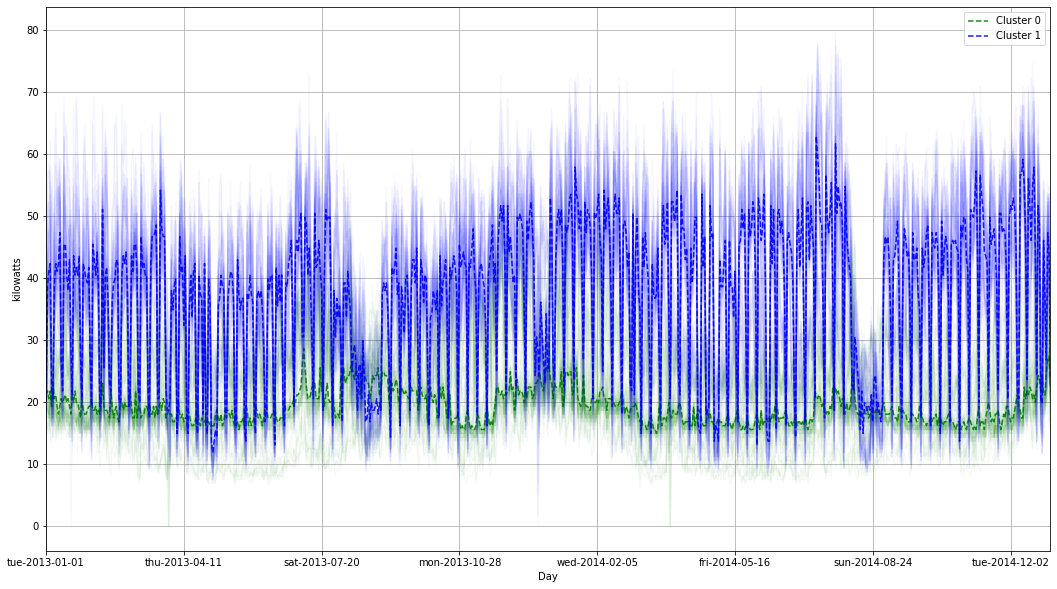

In [449]:
fig, ax= plt.subplots(1,1, figsize=(18,10))

cluster_values = sorted(dfX_updated.index.get_level_values('cluster').unique())
color_list = ['green','blue','red','magenta','orange','brown','purple','yellow','black','pink']

for cluster, color in zip(cluster_values, color_list):
    dfX_updated.xs(cluster, level=1).T.plot(ax=ax,legend=False, alpha=0.035, color=color)
    dfX_updated.xs(cluster, level=1).median().plot(ax=ax,legend=True,color=color, alpha=0.9, ls='--',label= f'Cluster {cluster}')

ax.set_ylabel('kilowatts')
ax.set_xlabel('Day')
ax.grid()

We can see that Cluster 1 (Blue) has a larger variance in the Kilowatt readings than Cluster 0 (Green), which is smoother and averages at about 20kW.

These could represent traces for early morning and late night hour power consumption, which would be typically lower and less subject to change (less sudden demand for electricity in the middle of the night for instance)

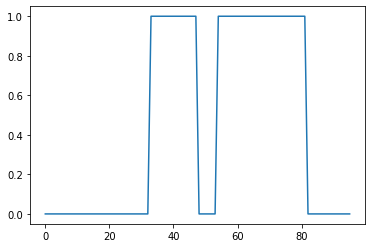

In [450]:
plt.plot(y_pred)

With the plot above, the distribution of Cluster 0 estimations at the earlier and later hours seems to fit this idea.

I will now reformat the data such that the x-axis will show the hours per day, and the curves will represent the power consumption trends per day. This may give us a clearer picture of hourly breakdown of power consumption than the previous analysis.

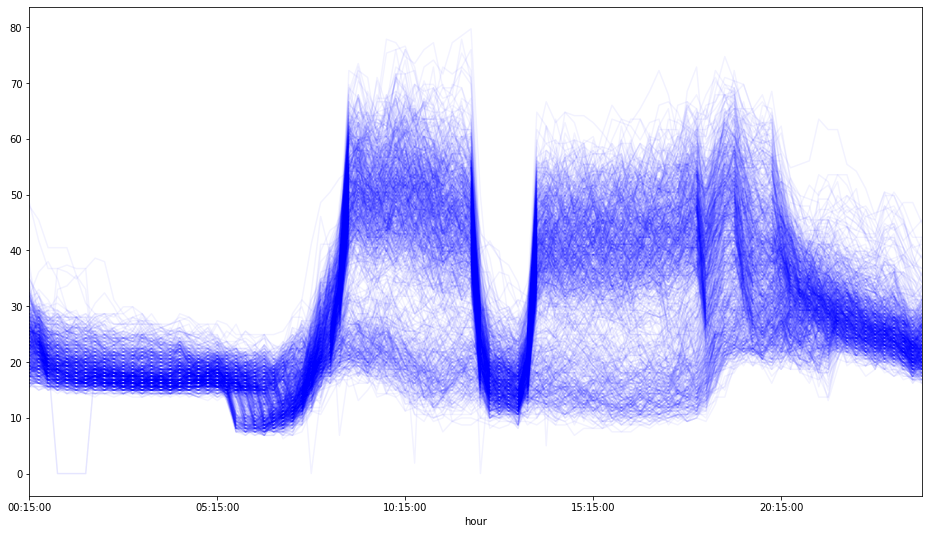

In [451]:
dfXT = dfX.T
dfXT.plot(figsize=(16,9), legend=False,color = 'blue', alpha=0.05)


The above plot shows the pattern of daily usage from 2013-2014 for a single client. The consumption trends are clearly visible, with lower usage during the morning and late night hours, and spikes during the rush-hour periods.

Again, the Silhouette scoring will be applied to determine optimal Kmean clusters:

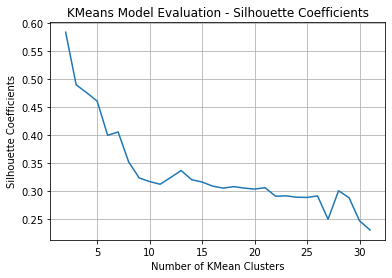

In [452]:
nClusterVals = np.linspace(2,31,30,dtype='int')  # Check 2 to 30 clusters (an obscenely high amount, but useful for demonstative purposes...)
silArray = []
for i in nClusterVals:
    y_pred = KMeans(n_clusters = i,n_init = 100).fit(dfXT)
    # Derive the silhouette scores using the sklearn metrics library
    silArray.append(silhouette_score(dfXT,y_pred.labels_, metric='euclidean'))

plt.plot(nClusterVals,silArray)
plt.title("KMeans Model Evaluation - Silhouette Coefficients")
plt.xlabel("Number of KMean Clusters")
plt.ylabel("Silhouette Coefficients")
plt.grid()

As with our previous analyses, we find that 2 kmeans clusters are the optimal amount.

In [453]:
dfXT_updated = dfXT.T
y_pred = KMeans(n_clusters = 2).fit_predict(dfXT_updated)
y_pred_sr = pd.Series(y_pred, name='cluster')
print(y_pred)
dfXT_updated = dfXT_updated.set_index(y_pred_sr, append=True )
dfXT_updated.tail(5)

[1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0
 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0
 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1
 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0
 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0
 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0
 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1
 1 0 0 0 1 1 1 1 0 0 0 0 

hour                     00:15:00   00:30:00   00:45:00   01:00:00   01:15:00  \
date           cluster                                                          
sat-2014-12-27 0        21.170610  21.793275  21.170610  20.547945  21.793275   
sun-2014-12-28 1        31.133250  29.265255  28.019925  28.019925  26.151930   
mon-2014-12-29 0        28.642590  29.887920  27.397260  28.642590  26.774595   
tue-2014-12-30 0        29.265255  29.887920  30.510585  28.642590  28.019925   
wed-2014-12-31 1        24.906600  26.774595  23.661270  22.415940  22.415940   

hour                     01:30:00   01:45:00   02:00:00   02:15:00   02:30:00  \
date           cluster                                                          
sat-2014-12-27 0        21.170610  19.925280  19.925280  19.925280  19.302615   
sun-2014-12-28 1        24.906600  24.906600  25.529265  25.529265  25.529265   
mon-2014-12-29 0        26.151930  26.774595  26.151930  26.774595  25.529265   
tue-2014-12-30 0        27.397260  28.642590  27.397260  28.642590  26.774595   
wed-2014-12-31 1        23.038605  21.793275  21.793275  21.170610  22.415940   

hour                    ...   21:45:00   22:00:00   22:15:00   22:30:00  \
date           cluster  ...                                               
sat-2014-12-27 0        ...  37.982565  38.605230  36.114570  37.982565   
sun-2014-12-28 1        ...  39.850560  38.605230  37.982565  32.378580   
mon-2014-12-29 0        ...  36.114570  34.246575  31.755915  31.133250   
tue-2014-12-30 0        ...  32.378580  33.623910  28.019925  25.529265   
wed-2014-12-31 1        ...  34.869240  34.869240  32.378580  33.001245   

hour                     22:45:00   23:00:00   23:15:00   23:30:00   23:45:00  \
date           cluster                                                          
sat-2014-12-27 0        37.359900  36.114570  37.359900  35.491905  32.378580   
sun-2014-12-28 1        32.378580  29.887920  33.001245  33.623910  29.887920   
mon-2014-12-29 0        33.001245  33.001245  36.114570  36.114570  32.378580   
tue-2014-12-30 0        26.151930  27.397260  29.265255  29.887920  24.283935   
wed-2014-12-31 1        32.378580  31.133250  34.246575  36.114570  34.246575   

hour                    00:00:00  
date           cluster            
sat-2014-12-27 0        28.64259  
sun-2014-12-28 1        26.15193  
mon-2014-12-29 0        29.88792  
tue-2014-12-30 0        23.66127  
wed-2014-12-31 1        31.13325  

[5 rows x 96 columns]

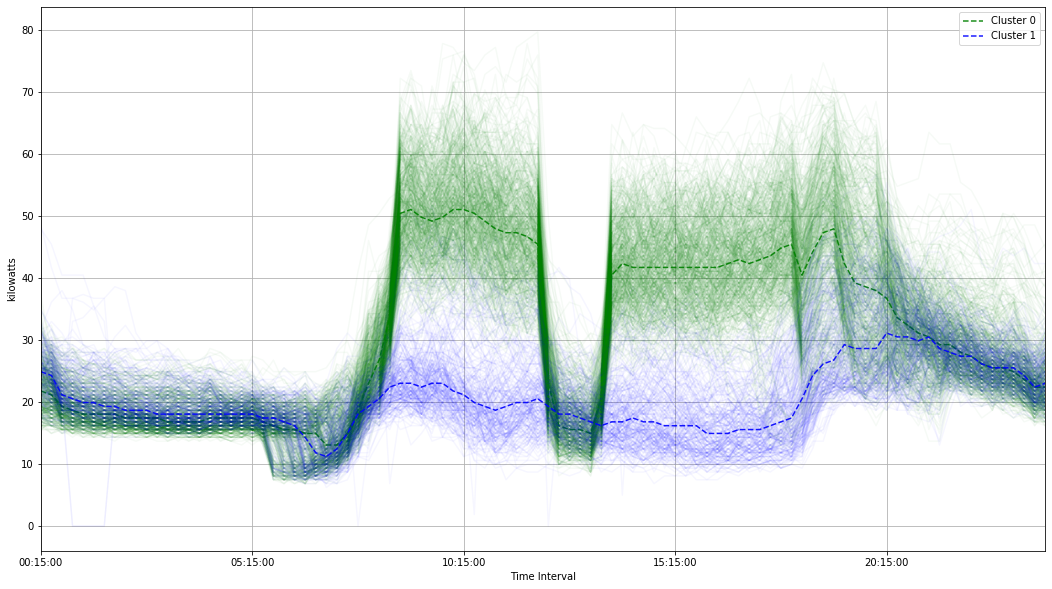

In [454]:
fig, ax= plt.subplots(1,1, figsize=(18,10))

cluster_values = sorted(dfXT_updated.index.get_level_values('cluster').unique())
color_list = ['green','blue','red','magenta','orange','brown','purple','yellow','black','pink']

for cluster, color in zip(cluster_values, color_list):
    dfXT_updated.xs(cluster, level=1).T.plot(ax=ax,legend=False, alpha=0.035, color=color)
    dfXT_updated.xs(cluster, level=1).median().plot(ax=ax,legend=True,color=color, alpha=0.9, ls='--',label= f'Cluster {cluster}')

ax.set_ylabel('kilowatts')
ax.set_xlabel('Time Interval')
ax.grid()

An interesting trend has been witnessed from the above plot. There is a large clustering of curves associated with average power consumption during the daytime hours via Cluster 1 (blue), as opposed to the morning and evening spikes previously witnessed with Cluster 0 (Green). These could potentially be due to weekend/weekday distributions. Examining the clustering % to see if we get a roughly 71%-29% split between the cluster distributions:

In [455]:
y_pred_sr.value_counts()/len(y_pred_sr)

0    0.7
1    0.3
Name: cluster, dtype: float64

We can see that cluster 0 (Green) has the same density as weekdays, while Cluster 1 has the same distribution as weekends (5/7 to 2/7). This would correspond with higher power spikes with people leaving/commuting to work, and returning home from work.

#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for pard (b)

In [456]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]